In [1]:
import pandas as pd

In [2]:
df = pd.read_csv('hw_data.csv')

# Описание

Мы хотим, чтобы пользователи нашего приложения возвращались в него чаще. Для этого мы решили рассылать Push-уведомления с полезной информацией, для этого пользователей разделили на три группы:

* Группу FORCE решили принудительно подписать на push-уведомления и посмотреть что будет
* Группу ASK, в которой спросили, хотят ли пользователи подписаться, и если да, начинали отправлять ему push'и, а если нет, то ничего не отправляли
* Группу OTHER - это все остальные, им мы ничего не рассылаем

Анализ решили проводить только на новых за этот период пользователях, поэтому самая ранняя дата для каждого пользователя - дата его первого посещения приложения (когда он пришел на сервис впервые).
Что есть в наших данных:

* exp_group - Название группы эксперимента
* dt - день посещения пользователем приложения
* platform - с какой платформы он пришел
* device_id - уникальный идентификатор пользователя

# Перевести в человеческого вида дату

In [4]:
df['date'] = pd.to_datetime(df['dt'],format='%d/%m/%y')

In [5]:
df

,exp_group,dt,device_id,platform,date
0,ASK,02/03/21,67974bec4b4c2dd2e5294b5208098fbe843026f7f6b2c4...,android,2021-03-02
1,OTHER,10/03/21,c4f890ef079ae647c67a00da6a7f5bb49e91ab531d18da...,android,2021-03-10
2,OTHER,08/03/21,c4f890ef079ae647c67a00da6a7f5bb49e91ab531d18da...,android,2021-03-08
3,OTHER,13/03/21,a3bfce93eceb1e564bbbe4a6c64509e2836573396ab51f...,android,2021-03-13
4,OTHER,14/03/21,761a1b1eae1361cb80e5b572baccd46f7439a37140f4d8...,android,2021-03-14
...,...,...,...,...,...
398929,OTHER,20/02/21,c70b1338542dcdd2686bd95e3a7de4251a0b8bfef92b2c...,android,2021-02-20
398930,OTHER,27/02/21,04fed97f7ed72d11640455a645261cc24b6de3a89d8072...,android,2021-02-27
398931,FORCE,18/02/21,43142d6933d9c0a411acdf2ad5eb5ac77735d5554fe406...,android,2021-02-18
398932,OTHER,09/03/21,0fccb2be58f3d969d4009cd729f686e39499fe47ba00d7...,android,2021-03-09


# Дальше нам пригодятся когорты

Посчитаем первую дату захода на сервис (Дата когорты - дата первого захода пользователя на сервис в нашем интервале)

In [6]:
min_date = df[['device_id','date']].groupby('device_id').min().reset_index()

In [7]:
min_date

,device_id,date
0,0000284750cfd6a08fa51baa0b3cc3dcecf9d6d39b9672...,2021-03-01
1,000055d50fa9455b2994def0c44d443096cc2955d91a5a...,2021-02-27
2,0000ce3afcf67a2b8d95c05639bd8b618f032d42eab5d9...,2021-03-10
3,0001587cdfd30032ccf588ec5295258e0f71185c9512e8...,2021-03-10
4,000160de23933144d041c9b963dadfd812b266a84b3871...,2021-03-15
...,...,...
199181,fffe64b77a699a38ca28f04d937c02d99abd29805ebc1c...,2021-02-20
199182,ffff086e9983b130e622b17f727562455e6d5a95feabab...,2021-03-04
199183,ffff11b82e8251d8c501ff6b1f389abca166c7fcb8947a...,2021-03-11
199184,ffff3a1a0d91b09ec2b26ad5f8f70cd86fe1c0edfaee53...,2021-02-24


# Приджойним эту дату обратно в наш df

In [8]:
df = df.merge(min_date, how='left', on = 'device_id', suffixes=('', '_cohort'))

In [9]:
df.head()

,exp_group,dt,device_id,platform,date,date_cohort
0,ASK,02/03/21,67974bec4b4c2dd2e5294b5208098fbe843026f7f6b2c4...,android,2021-03-02,2021-03-02
1,OTHER,10/03/21,c4f890ef079ae647c67a00da6a7f5bb49e91ab531d18da...,android,2021-03-10,2021-03-08
2,OTHER,08/03/21,c4f890ef079ae647c67a00da6a7f5bb49e91ab531d18da...,android,2021-03-08,2021-03-08
3,OTHER,13/03/21,a3bfce93eceb1e564bbbe4a6c64509e2836573396ab51f...,android,2021-03-13,2021-03-13
4,OTHER,14/03/21,761a1b1eae1361cb80e5b572baccd46f7439a37140f4d8...,android,2021-03-14,2021-03-10


# Проверим, что все как надо

In [46]:
import pandasql as ps

In [20]:
query = """
select device_id, date_cohort,platform, min(date) as min_dt
from df 
group by device_id, date_cohort
having min(date)!=date_cohort
"""

tst = ps.sqldf(query, locals())
tst

,device_id,date_cohort,platform,min_dt


# Народ по когортам (надо что-то спросить по графикам)

In [21]:
query = """
select date_cohort,exp_group,platform, count(distinct device_id) as devices
from df 
where platform = 'android'
group by date_cohort, platform, exp_group
order by platform,exp_group, cast(date_cohort as datetime)
"""

tst = ps.sqldf(query, locals())
tst

,date_cohort,exp_group,platform,devices
0,2021-02-16 00:00:00.000000,ASK,android,1245
1,2021-02-17 00:00:00.000000,ASK,android,1329
2,2021-02-18 00:00:00.000000,ASK,android,1189
3,2021-02-19 00:00:00.000000,ASK,android,1203
4,2021-02-20 00:00:00.000000,ASK,android,1378
...,...,...,...,...
79,2021-03-11 00:00:00.000000,OTHER,android,3676
80,2021-03-12 00:00:00.000000,OTHER,android,4120
81,2021-03-13 00:00:00.000000,OTHER,android,4760
82,2021-03-14 00:00:00.000000,OTHER,android,5050


In [22]:
tst['date_cohort'] = tst['date_cohort'].apply(lambda x: x[:10])

exp_group
ASK      AxesSubplot(0.125,0.125;0.775x0.755)
FORCE    AxesSubplot(0.125,0.125;0.775x0.755)
OTHER    AxesSubplot(0.125,0.125;0.775x0.755)
Name: devices, dtype: object

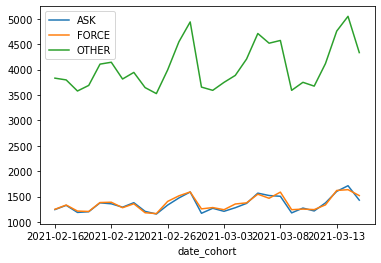

In [23]:
# tst.plot(x='cohort',y = 'devices')
tst.set_index("date_cohort", inplace=True)
tst.groupby("exp_group")["devices"].plot(legend=True)

# Вопрос 1

Сколько в среднем в день на платформе Андроид приходит новых пользователей в каждой из групп? 

В ответ ожидается csv-файл c двумя колонками:

**exp_group** и **avg_users**

Название группы.  Число новых пользователей

В **avg_users** запишите среднее значение, округленное до двух знаков после запятой.

# Вопрос 2

В какой день на платформе iOS пришло наибольшее кол-во пользователей из группы ASK (считать всех, не только новых)? 

В ответ ожидается csv-файл c двумя колонками:

**exp_group** и **max_date**

Название группы.  Дата

В **max_date** запишите дату в формате строки год-месяц-день. Например 2020-12-01

# Вопрос 3

Какой процент пользователей на платформе Android в каждой из групп вернулся на третий день после своего первого визита? 

Эта величина называется обычно возвращемостью третьего дня или Retention 3-го дня 

## КАК ЭТО ПОСЧИТАТЬ (например)

* Отбираете из df только ПЕРВЫЕ их визиты сохраняете в df_initial
* Отбираете из df только визиты, которые произошли НА ТРЕТИЙ день после первого. Например для каждого device_id посчитайте first_visit_date и выберите такие визиты, для которых date - first_visit_date будет равно трем дням. Назовем это df_third
* Присоединяете к df_initial данные из df_third c помощью операции merge в стиле "left join". 
* Считаете всех пользователей по группам, которые пришли до 12 марта (назовем это group_size)
* Считаете всех пользователей по группам, которые вернулись на третий день после 1 визита (назовем это cameback_3d)
* Для каждой группы считаем cameback_3d/group_size. Это и есть retention

[Про типы merge](https://www.shanelynn.ie/merge-join-dataframes-python-pandas-index-1/)

Последняя дата из df_initial которую нужно учитывать в расчете retention 3 дня - 12 марта (потому что последняя дата - 15ое)


В ответ ожидается dataframe c двумя колонками:

**exp_group** и **retention**

Название группы.  Доля вернувшихся

Ответ округлить до двух знаков после запятой

Пример:

    exp_group        retention

    ASK              0.11



# Вопрос 4

Давайте попробуем понять, сколько в каждом месяце было уникальных клиентов, которым решили отправлять PUSH уведомления. Введите в ответ численное значение

# Задания 5

Введите ID пользователя, который дольше всего был активен в приложении (максимальное значение по времени между первой датой и последней датой). Если встречается несколько таких пользователей, в ответ введите первый ID согласно лексикографической сортировке.

# Задание 7

Постройте график распределения визитов пользователей по неделям (подсмотрите в описании библиотеки datetime, как достать из даты номер недели). В ответ введите номер недели, когда в среднем за день недели пользователей с платформы Android было минимальное количество (количество пользователей за неделю делить на количество дней в этой неделе). Заметьте, что внутри теста может быть, например, неделя из четырех дней (если тест запустился в четверг).

# Задание 8

Вычислите, какое количество пользователей из группы FORCE (из нашего датасета) больше не заходило в наше приложение после первого визита. В ответ запишите долю таких пользователей от всех пользователей нашего приложения (из нашего датасета).

In [36]:
tt = df[['device_id','diff']].groupby('device_id').max().reset_index()
117311/len(df['device_id'].unique())
# tt[tt['diff']==0].shape[0]/total

0.588952034781561

# Задание 9
Главный вопрос - а предлагать ли пользователям подписываться или нет. Рассчитайте доли пользователей которые заходили в приложение более трех раз после инициализации. В ответ запишите группу, в которой эта доля оказалась наибольшей.

In [26]:
query = """
    select exp_group, 
        count(distinct device_id) as group_size,
        count(distinct device_new_visit) as more_than_three
    from (
        select exp_group, device_id,
            case when count()  > 3 then device_id else null end as device_new_visit
        from df 
        group by exp_group, device_id
        )
    group by exp_group
"""

tst = ps.sqldf(query, locals())
tst

,exp_group,group_size,more_than_three
0,ASK,39723,4996
1,FORCE,40119,5590
2,OTHER,119344,15135


In [27]:
tst['frequent_visitors'] = tst['more_than_three']/tst['group_size']
tst

,exp_group,group_size,more_than_three,frequent_visitors
0,ASK,39723,4996,0.125771
1,FORCE,40119,5590,0.139335
2,OTHER,119344,15135,0.126818
